# Prognozowanie indeksu WIG różnymi metodami

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import *

In [2]:
os.chdir('.../temp/Wig')

df = pd.read_csv('wig_m.csv', sep=';', usecols=[0, 4])
df['Data'] = df['Data'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df = df[df['Data'] >= datetime.strptime('01.01.1993', '%d.%m.%Y')].reset_index(drop=True)
daty = df['Data'].map(lambda x: str(x)[:7])
df =  df.drop(['Data'], axis=1)

In [3]:
def daty_full(n):
	daty_pred = pd.core.series.Series([datetime.strptime('2018-11-01', '%Y-%m-%d')+relativedelta(months=+i) for i in range(n)])	 \
		.map(lambda x: str(x.year)+'-0'+str(x.month))
	return daty.append(daty_pred).reset_index(drop=True)

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def forecast(X, reg, n=30):
	forecastX = X[-1:]; predY = np.zeros(1)
	for i in range(n):
	    forecastY = reg.predict(forecastX)
	    forecastX = np.array([np.append(forecastX, forecastY)])
	    forecastX = forecastX[:,1:]
	    predY = np.append(predY, forecastY)
	predY = predY[1:]
	predYp = np.append(np.array([np.nan]*len(df)), predY)
	return predYp


Regresja liniowa

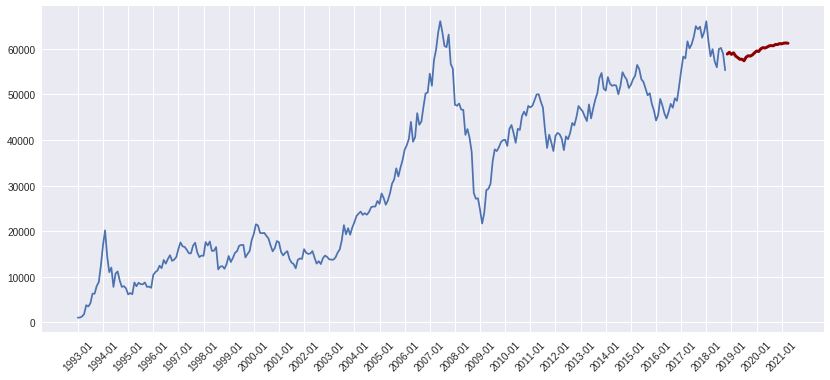

In [4]:
from sklearn.linear_model import LinearRegression

look_back = 24; look_ahead = 30
X, y = create_dataset(df.values, look_back)

reg = LinearRegression().fit(X, y)
reg.coef_ , reg.intercept_
reg.score(X, y)

predYp = forecast(X, reg, look_ahead)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Regresja z wielomianami

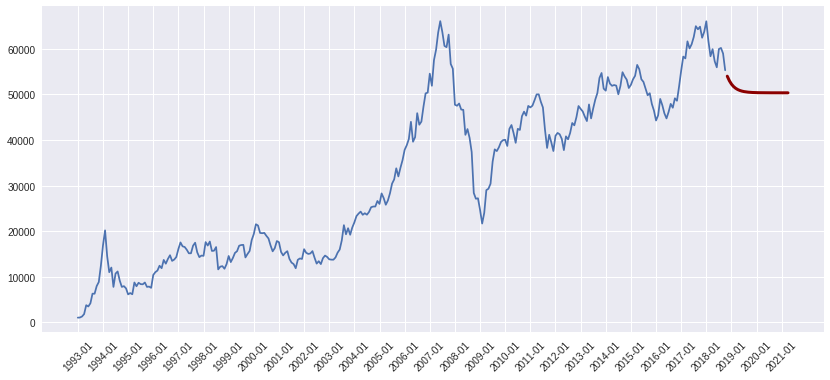

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = df.iloc[:-1]; y = df.iloc[1:]

pf = PolynomialFeatures(degree=5, include_bias=False)
polyX = pf.fit_transform(X)
reg = LinearRegression().fit(polyX, y)
reg.coef_ , reg.intercept_
reg.score(polyX, y)

forecastX = y.values[-1:]; predY = np.zeros(1); look_ahead = 30
for i in range(look_ahead):
    forecastY = reg.predict(pf.fit_transform(forecastX.reshape(-1,1)))
    forecastX = forecastY
    predY = np.append(predY, forecastY)
predY = predY[1:]
predYp = np.append(np.array([np.nan]*len(df)), predY)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Regresja LASSO

/home/sas/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


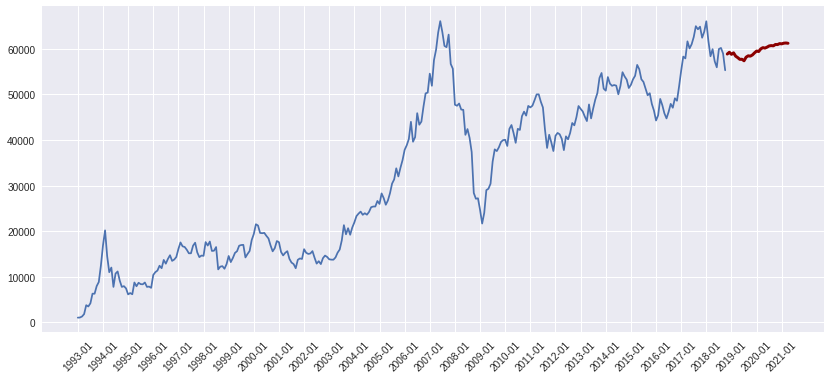

In [9]:
from sklearn.linear_model import Lasso

look_back = 24; look_ahead = 30
X, y = create_dataset(df.values, look_back)

reg = Lasso(alpha=5.0, max_iter=1000).fit(X, y)
reg.coef_ , reg.intercept_
reg.score(X, y)

predYp = forecast(X, reg, look_ahead)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Regresja LASSO z doborem parametrów

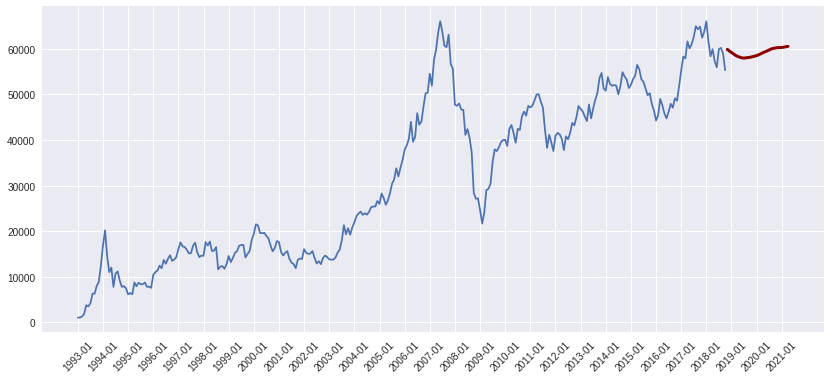

In [17]:
from sklearn.linear_model import LassoLarsCV

look_back = 30; look_ahead = 30
X, y = create_dataset(df.values, look_back)

reg = LassoLarsCV(cv=10, precompute=False).fit(X, y)
reg.coef_ , reg.intercept_ , reg.alphas_
reg.score(X, y)

predYp = forecast(X, reg, look_ahead)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Regresja LASSO z wielomianami

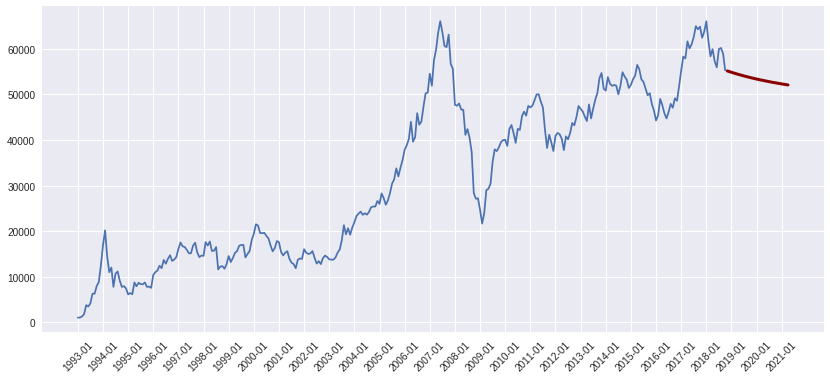

In [30]:
X = df.iloc[:-1]; y = df.iloc[1:]

pf = PolynomialFeatures(degree=5, include_bias=False)
polyX = pf.fit_transform(X)
reg = Lasso(alpha=0.8, fit_intercept=True, normalize=True, max_iter=1000, tol=0.01, warm_start=False).fit(polyX,y)
reg.coef_ , reg.intercept_
reg.score(polyX, y)

forecastX = y.values[-1:]; predY = np.zeros(1); look_ahead = 30
for i in range(look_ahead):
    forecastY = reg.predict(pf.fit_transform(forecastX.reshape(-1,1)))
    forecastX = forecastY
    predY = np.append(predY, forecastY)
predY = predY[1:]
predYp = np.append(np.array([np.nan]*len(df)), predY)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Regresja SVR

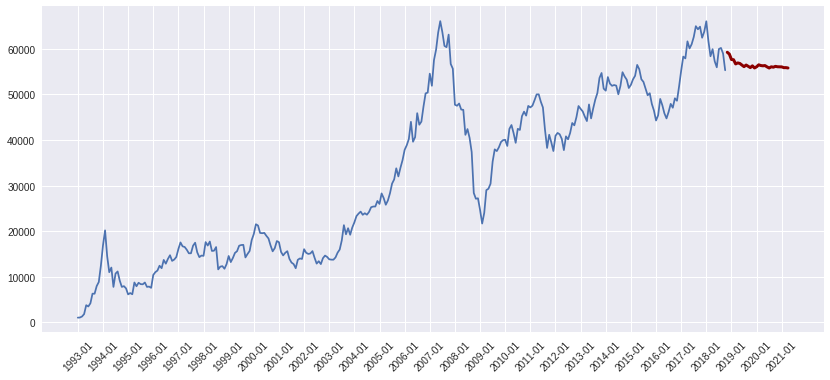

In [46]:
from sklearn.svm import LinearSVR

look_back = 24; look_ahead = 30
X, y = create_dataset(df.values, look_back)

reg = LinearSVR(C=1.0, epsilon=1.0).fit(X, y)
reg.coef_ , reg.intercept_
reg.score(X, y)

predYp = forecast(X, reg, look_ahead)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Regresja gradientowa

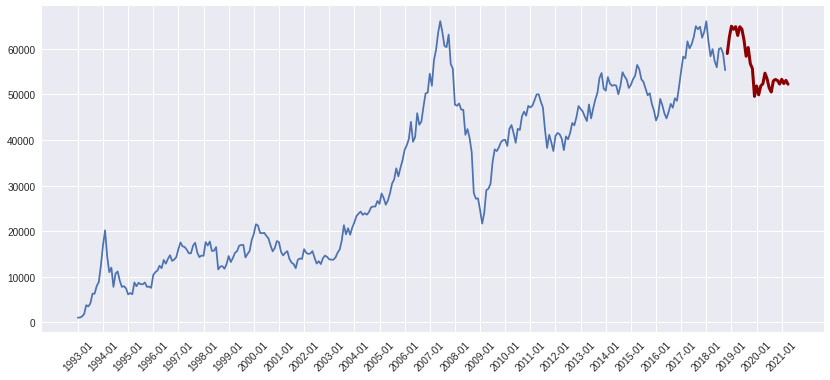

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

look_back = 6; look_ahead = 30
X, y = create_dataset(df.values, look_back)

reg = GradientBoostingRegressor(max_depth=10, n_estimators=20, learning_rate=0.5).fit(X, y)
predYp = forecast(X, reg, look_ahead)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

AdaBoost

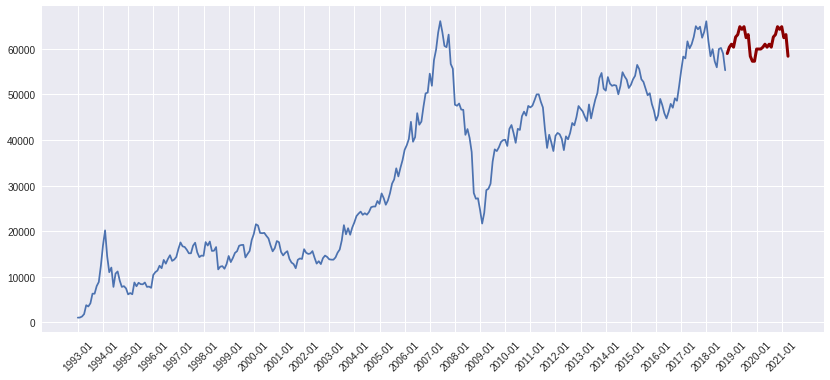

In [51]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

look_back = 6; look_ahead = 30
X, y = create_dataset(df.values, look_back)

reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20), n_estimators=100, learning_rate=1.0).fit(X, y)
predYp = forecast(X, reg, look_ahead)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

ARIMA

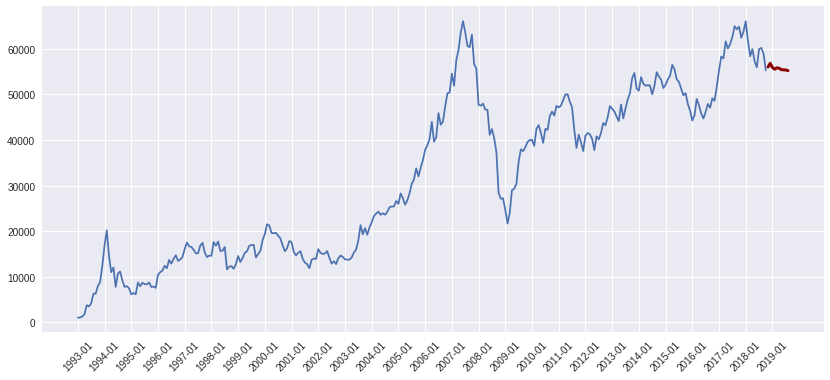

In [54]:
from statsmodels.tsa.arima_model import ARIMA

X = df.iloc[-20:]; predY = np.zeros(1); look_ahead = 10

for i in range(look_ahead):
    model = ARIMA(X, order=(4,1,0))
    model_fit = model.fit()
    forecastY = model_fit.forecast()[0]
    predY = np.append(predY, forecastY)
    X = np.append(X, forecastY)

predY = predY[1:]
predYp = np.append(np.array([np.nan]*len(df)), predY)

plt.figure(figsize=(14,6));
plt.plot(df)
plt.plot(daty_full(look_ahead), predYp, c='darkred', lw=3)
plt.xticks(np.arange(0, len(df)+look_ahead, step=12), rotation=45)
plt.show()

Sieć neuronowa

In [30]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

look_back = 24; look_ahead = 30
scaler.fit(df.values)
X, y = create_dataset(scaler.transform(df.values), look_back)

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X)
reg = tf.contrib.learn.DNNRegressor(hidden_units=[30,30,30], feature_columns=feature_cols, activation_fn=tf.nn.tanh)
reg.fit(X, y, batch_size=1, steps=30)

pred_ob = reg.predict(X)
pred = []
for e in pred_ob:
	pred = np.append(pred, e)

forecastX = X[-1:]; predY = np.zeros(1)
for i in range(look_ahead):
	predF = []
	pred_ob = reg.predict(forecastX)
	for e in pred_ob:
		pred_f = np.append(predF, e)

	forecastX = np.array([np.append(forecastX, pred_f)])
	forecastX = forecastX[:,1:]
	predY = np.append(predY, pred_f)
predY = predY[1:]

y_pred = scaler.inverse_transform(np.array(pred).reshape(-1,1))
y_base = scaler.inverse_transform(np.array(y).reshape(-1,1))
pred_Yunsc = scaler.inverse_transform(np.array(predY).reshape(-1,1))
pred_Yp = np.append(np.array([np.nan]*len(X)), pred_Yunsc)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8168822f60>, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_task_id': 0, '_save_checkpoints_steps': None, '_environment': 'local', '_evaluation_master': '', '_tf_random_seed': None, '_master': '', '_is_chief': True, '_task_type': None, '_keep_checkpoint_max': 5}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y 

/home/sas/anaconda3/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp2189d_h3/model.ckpt.
INFO:tensorflow:step = 1, loss = 0.0248771
INFO:tensorflow:Saving checkpoints for 30 into /tmp/tmp2189d_h3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00395664.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving 

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving 

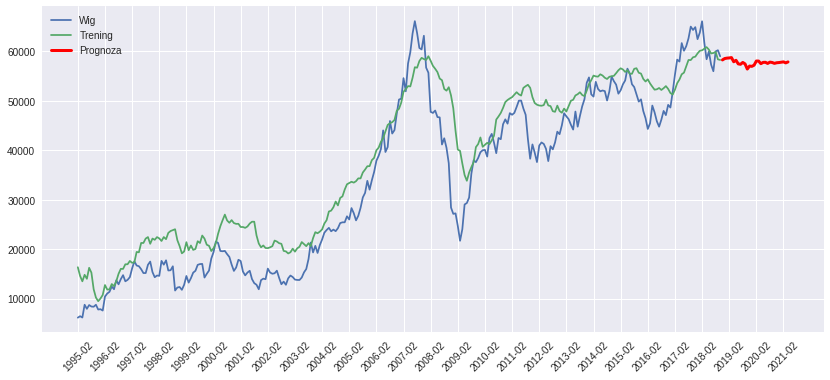

In [33]:
plt.figure(figsize=(14,6))
plt.plot(y_base); plt.plot(y_pred)
plt.plot(daty_full(look_ahead)[look_back+1:], pred_Yp, c='r', lw=3)
plt.xticks(np.arange(0, len(X)+look_ahead, step=12), rotation=45)
plt.legend(['Wig','Trening','Prognoza'], loc='upper left')
plt.show()